In [5]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import sklearn as sk
import seaborn as sb
import matplotlib.pyplot as pp
from sklearn.preprocessing import OneHotEncoder
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge, Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, r2_score, make_scorer

from numpy import mean

In [6]:
train_id = pd.read_csv( 'train_identity.csv' )
train_tran = pd.read_csv( 'train_transaction.csv' )
FraudDetection = pd.merge( train_tran, train_id, on='TransactionID', how='left')

In [7]:
FraudDetection.describe()

,TransactionID,isFraud,TransactionDT,TransactionAmt,card1,card2,card3,card5,addr1,addr2,...,id_17,id_18,id_19,id_20,id_21,id_22,id_24,id_25,id_26,id_32
count,5.905400e+05,590540.000000,5.905400e+05,590540.000000,590540.000000,581607.000000,588975.000000,586281.000000,524834.000000,524834.000000,...,139369.000000,45113.000000,139318.000000,139261.000000,5159.000000,5169.000000,4747.000000,5132.000000,5163.000000,77586.000000
mean,3.282270e+06,0.034990,7.372311e+06,135.027176,9898.734658,362.555488,153.194925,199.278897,290.733794,86.800630,...,189.451377,14.237337,353.128174,403.882666,368.269820,16.002708,12.800927,329.608924,149.070308,26.508597
std,1.704744e+05,0.183755,4.617224e+06,239.162522,4901.170153,157.793246,11.336444,41.244453,101.741072,2.690623,...,30.375360,1.561302,141.095343,152.160327,198.847038,6.897665,2.372447,97.461089,32.101995,3.737502
min,2.987000e+06,0.000000,8.640000e+04,0.251000,1000.000000,100.000000,100.000000,100.000000,100.000000,10.000000,...,100.000000,10.000000,100.000000,100.000000,100.000000,10.000000,11.000000,100.000000,100.000000,0.000000
25%,3.134635e+06,0.000000,3.027058e+06,43.321000,6019.000000,214.000000,150.000000,166.000000,204.000000,87.000000,...,166.000000,13.000000,266.000000,256.000000,252.000000,14.000000,11.000000,321.000000,119.000000,24.000000
50%,3.282270e+06,0.000000,7.306528e+06,68.769000,9678.000000,361.000000,150.000000,226.000000,299.000000,87.000000,...,166.000000,15.000000,341.000000,472.000000,252.000000,14.000000,11.000000,321.000000,149.000000,24.000000
75%,3.429904e+06,0.000000,1.124662e+07,125.000000,14184.000000,512.000000,150.000000,226.000000,330.000000,87.000000,...,225.000000,15.000000,427.000000,533.000000,486.500000,14.000000,15.000000,371.000000,169.000000,32.000000
max,3.577539e+06,1.000000,1.581113e+07,31937.391000,18396.000000,600.000000,231.000000,237.000000,540.000000,102.000000,...,229.000000,29.000000,671.000000,661.000000,854.000000,44.000000,26.000000,548.000000,216.000000,32.000000


In [8]:
for col in FraudDetection.columns:
    Column = FraudDetection[col]
    if Column.dtype == 'object':
        if FraudDetection[col].isnull().mean(): FraudDetection = FraudDetection.drop( columns = col )
        else: FraudDetection[col].fillna( Column.mode()[0], inplace=True )
    else:
        FraudDetection[col].fillna( Column.mean(), inplace=True )
FraudDetection

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card5,addr1,...,id_17,id_18,id_19,id_20,id_21,id_22,id_24,id_25,id_26,id_32
0,2987000,0,86400,68.50,W,13926,362.555488,150.0,142.0,315.0,...,189.451377,14.237337,353.128174,403.882666,368.26982,16.002708,12.800927,329.608924,149.070308,26.508597
1,2987001,0,86401,29.00,W,2755,404.000000,150.0,102.0,325.0,...,189.451377,14.237337,353.128174,403.882666,368.26982,16.002708,12.800927,329.608924,149.070308,26.508597
2,2987002,0,86469,59.00,W,4663,490.000000,150.0,166.0,330.0,...,189.451377,14.237337,353.128174,403.882666,368.26982,16.002708,12.800927,329.608924,149.070308,26.508597
3,2987003,0,86499,50.00,W,18132,567.000000,150.0,117.0,476.0,...,189.451377,14.237337,353.128174,403.882666,368.26982,16.002708,12.800927,329.608924,149.070308,26.508597
4,2987004,0,86506,50.00,H,4497,514.000000,150.0,102.0,420.0,...,166.000000,14.237337,542.000000,144.000000,368.26982,16.002708,12.800927,329.608924,149.070308,32.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
590535,3577535,0,15811047,49.00,W,6550,362.555488,150.0,226.0,272.0,...,189.451377,14.237337,353.128174,403.882666,368.26982,16.002708,12.800927,329.608924,149.070308,26.508597
590536,3577536,0,15811049,39.50,W,10444,225.000000,150.0,224.0,204.0,...,189.451377,14.237337,353.128174,403.882666,368.26982,16.002708,12.800927,329.608924,149.070308,26.508597
590537,3577537,0,15811079,30.95,W,12037,595.000000,150.0,224.0,231.0,...,189.451377,14.237337,353.128174,403.882666,368.26982,16.002708,12.800927,329.608924,149.070308,26.508597
590538,3577538,0,15811088,117.00,W,7826,481.000000,150.0,224.0,387.0,...,189.451377,14.237337,353.128174,403.882666,368.26982,16.002708,12.800927,329.608924,149.070308,26.508597


In [9]:
for col in FraudDetection.select_dtypes( include = ['object'] ).columns:
    encoder = OneHotEncoder( sparse_output = False ).set_output( transform = 'pandas' )
    transformed = encoder.fit_transform(FraudDetection[[col]])
    encoded = pd.DataFrame(transformed, columns = encoder.get_feature_names_out([col]))
    FraudDetection = pd.concat([FraudDetection, encoded], axis=1).drop(columns=[col])
FraudDetection

,TransactionID,isFraud,TransactionDT,TransactionAmt,card1,card2,card3,card5,addr1,addr2,...,id_22,id_24,id_25,id_26,id_32,ProductCD_C,ProductCD_H,ProductCD_R,ProductCD_S,ProductCD_W
0,2987000,0,86400,68.50,13926,362.555488,150.0,142.0,315.0,87.0,...,16.002708,12.800927,329.608924,149.070308,26.508597,0.0,0.0,0.0,0.0,1.0
1,2987001,0,86401,29.00,2755,404.000000,150.0,102.0,325.0,87.0,...,16.002708,12.800927,329.608924,149.070308,26.508597,0.0,0.0,0.0,0.0,1.0
2,2987002,0,86469,59.00,4663,490.000000,150.0,166.0,330.0,87.0,...,16.002708,12.800927,329.608924,149.070308,26.508597,0.0,0.0,0.0,0.0,1.0
3,2987003,0,86499,50.00,18132,567.000000,150.0,117.0,476.0,87.0,...,16.002708,12.800927,329.608924,149.070308,26.508597,0.0,0.0,0.0,0.0,1.0
4,2987004,0,86506,50.00,4497,514.000000,150.0,102.0,420.0,87.0,...,16.002708,12.800927,329.608924,149.070308,32.000000,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
590535,3577535,0,15811047,49.00,6550,362.555488,150.0,226.0,272.0,87.0,...,16.002708,12.800927,329.608924,149.070308,26.508597,0.0,0.0,0.0,0.0,1.0
590536,3577536,0,15811049,39.50,10444,225.000000,150.0,224.0,204.0,87.0,...,16.002708,12.800927,329.608924,149.070308,26.508597,0.0,0.0,0.0,0.0,1.0
590537,3577537,0,15811079,30.95,12037,595.000000,150.0,224.0,231.0,87.0,...,16.002708,12.800927,329.608924,149.070308,26.508597,0.0,0.0,0.0,0.0,1.0
590538,3577538,0,15811088,117.00,7826,481.000000,150.0,224.0,387.0,87.0,...,16.002708,12.800927,329.608924,149.070308,26.508597,0.0,0.0,0.0,0.0,1.0


In [10]:
cor = FraudDetection.corr()

In [11]:
x = FraudDetection.drop( columns = 'isFraud' )
y = FraudDetection['isFraud']

y_corrs = cor['isFraud'].drop('isFraud').abs()
columns = y_corrs[ y_corrs < 0.2 ].index
x.drop( columns = columns, inplace = True )
x

,V44,V45,V52,V86,V87,V188,V189,V200,V201,V242,V244,V246,V257,V258
0,1.083891,1.120779,0.182695,1.000000,1.000000,1.014755,1.038314,1.119977,1.159106,1.113463,1.118562,1.183723,1.250993,1.34351
1,1.000000,1.000000,0.000000,1.000000,1.000000,1.014755,1.038314,1.119977,1.159106,1.113463,1.118562,1.183723,1.250993,1.34351
2,1.000000,1.000000,0.000000,1.000000,1.000000,1.014755,1.038314,1.119977,1.159106,1.113463,1.118562,1.183723,1.250993,1.34351
3,1.000000,1.000000,0.000000,1.000000,1.000000,1.014755,1.038314,1.119977,1.159106,1.113463,1.118562,1.183723,1.250993,1.34351
4,1.083891,1.120779,0.182695,1.064885,1.099456,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
590535,1.083891,1.120779,0.182695,1.000000,1.000000,1.014755,1.038314,1.119977,1.159106,1.113463,1.118562,1.183723,1.250993,1.34351
590536,1.000000,1.000000,0.000000,1.000000,1.000000,1.014755,1.038314,1.119977,1.159106,1.113463,1.118562,1.183723,1.250993,1.34351
590537,1.000000,1.000000,0.000000,1.000000,1.000000,1.014755,1.038314,1.119977,1.159106,1.113463,1.118562,1.183723,1.250993,1.34351
590538,1.000000,1.000000,1.000000,1.000000,1.000000,1.014755,1.038314,1.119977,1.159106,1.113463,1.118562,1.183723,1.250993,1.34351


In [12]:
import pickle

with open( 'variables.pkl', 'wb' ) as f:
    pickle.dump( FraudDetection, f )
    pickle.dump( x, f )
    pickle.dump( cor, f )

In [13]:
#import pickle
#with open( 'variables.pkl', 'rb' ) as f:
#    FraudDetection = pickle.load( f )
#    x = pickle.load( f )
#    cor = pickle.load( f )

In [14]:
while True:
    if len(x.columns) == 1: break
    vif = pd.DataFrame()
    vif['Variable'] = x.columns
    vif['Value'] = [ variance_inflation_factor( x.values, i ) for i in range(x.shape[1]) ]
    if vif.max()['Value'] < 5: break
    var = vif.max()['Variable']
    val = vif.max()['Value']
    print( f'Se elimina {var} con un VIF: {val}' )
    x = x.drop( columns = vif.max()['Variable'] )
x

Se elimina V87 con un VIF: 293.4554471094626
Se elimina V86 con un VIF: 293.3148283836189
Se elimina V52 con un VIF: 292.5088952138559
Se elimina V45 con un VIF: 291.9719315097914
Se elimina V44 con un VIF: 291.95491260466446
Se elimina V258 con un VIF: 291.6433379965566
Se elimina V257 con un VIF: 284.9965977886
Se elimina V246 con un VIF: 274.13530237709915
Se elimina V244 con un VIF: 253.3153295220337
Se elimina V242 con un VIF: 196.40080861418147
Se elimina V201 con un VIF: 183.38893756778114
Se elimina V200 con un VIF: 50.561605028040496
Se elimina V189 con un VIF: 42.98579310505311


,V188
0,1.014755
1,1.014755
2,1.014755
3,1.014755
4,1.000000
...,...
590535,1.014755
590536,1.014755
590537,1.014755
590538,1.014755


## Modelos de Clasificación

Dada la naturaleza de los modelos, se partirá el set en entrenamiento y test con tal de encontrar los mejores parámetros para ambas regresiones. En este caso, dado que los datos no están ordenados en cuanto a la variable respuesta, no es necesaria una validación cruzada estratificada. En este caso, lo mejor podria ser una validación aleatorea, pero por cuestión de resursos de memoria se usarán unicamente particiones por KFolds en la menor cantidad de particiones posibles para acelerar el proceso de modelado dada la magnitud de los datos.

In [15]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import recall_score, precision_score, f1_score, roc_auc_score
from sklearn.pipeline import Pipeline
x_train, x_test, y_train, y_test = train_test_split( x, y )

In [29]:
pipeline = Pipeline([('classifier', KNeighborsClassifier())])

param_grid = [
    {
        'classifier': [KNeighborsClassifier()],
        'classifier__n_neighbors': [ i for i in range( 1, 5 ) ]
    },
    {
        'classifier': [LogisticRegression()],
        'classifier__C': [ 10**i for i in range(-1,2) ]
    }
]

gs = GridSearchCV( pipeline, param_grid, cv = 3, scoring = 'roc_auc', n_jobs=6 )
gs.fit( x_train, y_train )
print(gs.best_params_)
print(f'Mejor puntaje en el entrenamiento: {gs.best_score_}')
print(f'Puntaje en la prueba: {gs.score( x_test, y_test )}')

{'classifier': KNeighborsClassifier(), 'classifier__n_neighbors': 4}
Mejor puntaje en el entrenamiento0.5388356465326051
Puntaje en la prueba: 0.5409186143668029


In [30]:
with open( 'model.pkl', 'wb' ) as f:
    pickle.dump( gs, f )
    pickle.dump( x_train, f )
    pickle.dump( y_train, f )
    pickle.dump( x_test, f )
    pickle.dump( y_test, f )

De aquí obtemenos que el mejor modelo es un 4-nn con un AUC medio de 0.54 y 0.54 para el set de prueba. Ahora bien, analizemos mejor el modelo realizado.

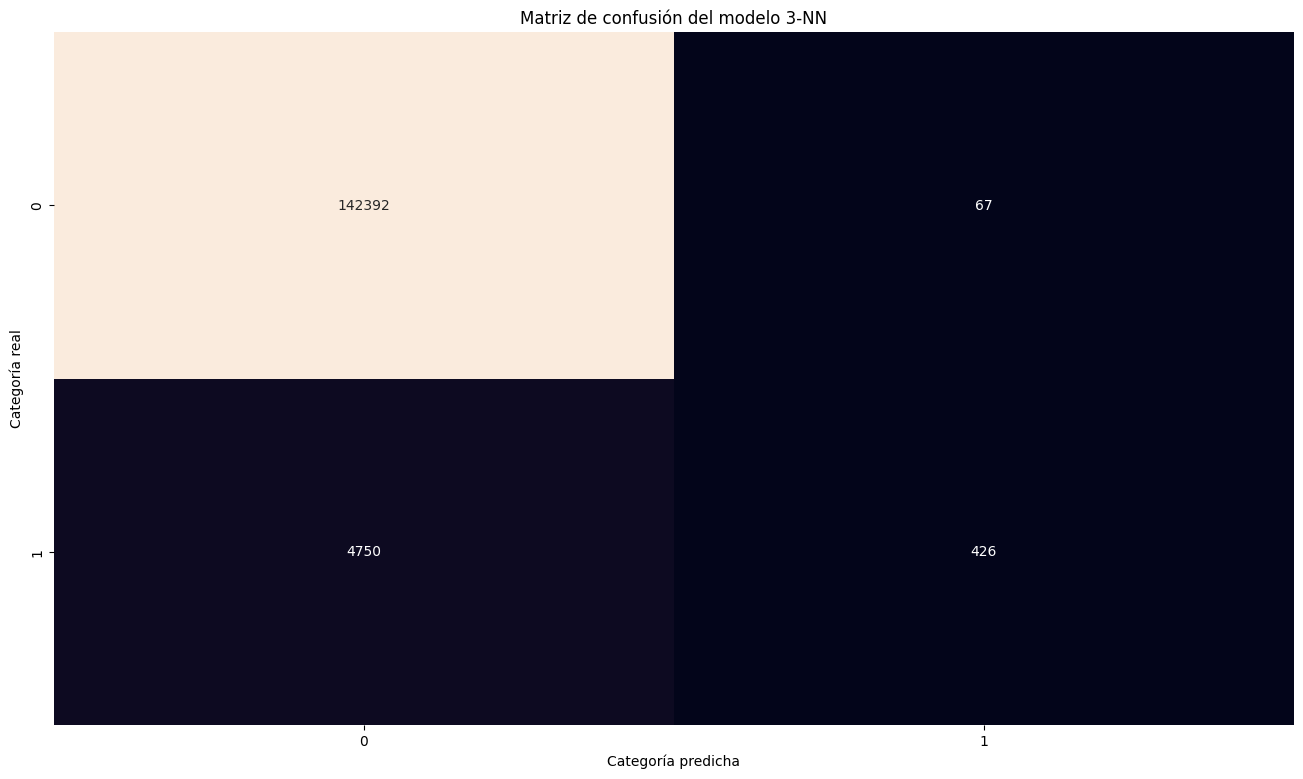

In [33]:
from sklearn.metrics import confusion_matrix, roc_curve, auc

y_pred = gs.predict( x_test )

pp.figure( figsize = (16,9) )
sb.heatmap( confusion_matrix( y_test, y_pred ), annot = True, fmt = 'd', cbar = False )
pp.xlabel('Categoría predicha')
pp.ylabel('Categoría real')
pp.title('Matriz de confusión del modelo 4-NN')
pp.show()

De la matriz de confución podemos ver que tiene una mayor tendencia a marcar como válida la transacción, a coste de dejar pasar muchas transacciones invalidas. Esto confirma que el modelo no es apropiado para la clasificación.

In [ ]:
f, t, threshold = roc_curve( y_test, gs.predict_proba(x_test)[:,1] )
rocAuc = auc(f,t)

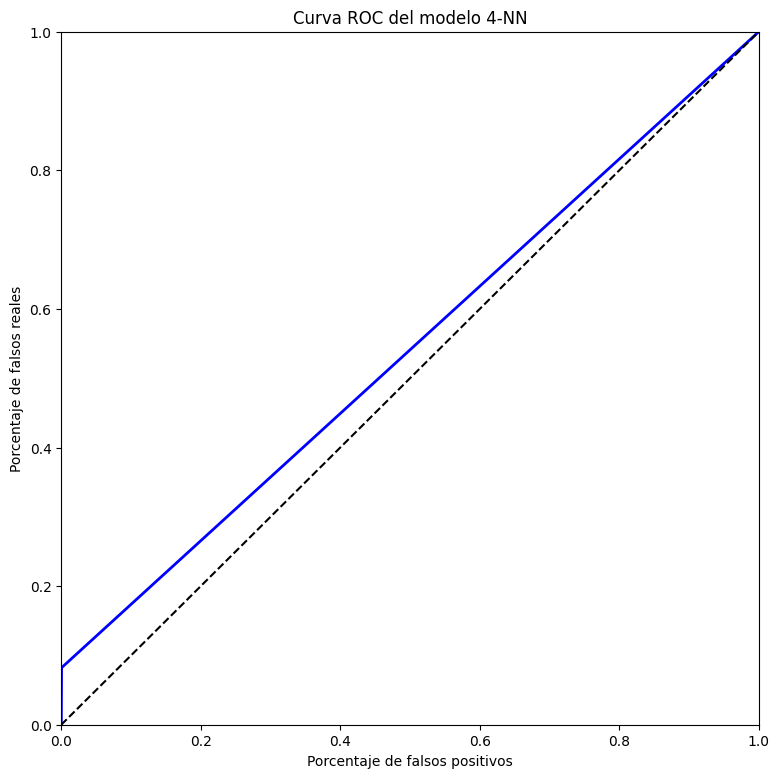

In [37]:
pp.figure( figsize = (9,9) )
pp.plot( f, t, color = 'blue', lw = 2, label = 'Curva ROC' )
pp.plot( [0,1], [0,1], color = 'black', linestyle = '--' )
pp.xlim([0,1])
pp.ylim([0,1])
pp.xlabel('Porcentaje de falsos positivos')
pp.ylabel('Porcentaje de falsos reales')
pp.title('Curva ROC del modelo 4-NN')
pp.show()

Podemos ver que el área bajo la curva es casi igual al área sobre la curva, por lo que como se menciona antes, el modelo es un mal predictor. 